# A Hierarchical model for Rugby prediction

:::{post} 19 Mar, 2022
:tags: hierarchical model, sports 
:category: intermediate, how-to
:author: Peadar Coyle, Meenal Jhajharia, Oriol Abril-Pla
:::

In this example, we're going to reproduce the first model described in {cite:t}`baio2010bayesian` using PyMC. Then show how to sample from the posterior predictive to simulate championship outcomes from the scored goals which are the modeled quantities.

We apply the results of the paper to the Six Nations Championship, which is a competition between Italy, Ireland, Scotland, England, France and Wales.

## Motivation
Your estimate of the strength of a team depends on your estimates of the other strengths

Ireland are a stronger team than Italy for example - but by how much?

Source for Results 2014 are Wikipedia. I've added the subsequent years, 2015, 2016, 2017. Manually pulled from Wikipedia.

* We want to infer a latent parameter - that is the 'strength' of a team based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team.
* Probabilistic Programming is a brilliant paradigm for modeling these **latent** parameters
* Aim is to build a model for the upcoming Six Nations in 2018.

:::{include} ../extra_installs.md
:::

In [1]:
!date

import arviz.preview as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

lun 15 dic 2025 12:33:57 EET


In [2]:
az.style.use("arviz-variat")
plt.rcParams["figure.constrained_layout.use"] = False

This is a Rugby prediction exercise. So we'll input some data. We've taken this from Wikipedia and BBC sports.

In [3]:
try:
    df_all = pd.read_csv("../data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

## What do we want to infer?

* We want to infer the latent parameters (every team's strength) that are generating the data we observe (the scorelines).
* Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.
* Often we don't know what the Bayesian Model is explicitly, so we have to 'estimate' the Bayesian Model'
* If we can't solve something, approximate it.
* Markov-Chain Monte Carlo (MCMC) instead draws samples from the posterior.
* Fortunately, this algorithm can be applied to almost any model.

## What do we want?

* We want to quantify our uncertainty
* We want to also use this to generate a model
* We want the answers as distributions not point estimates

### Visualization/EDA
We should do some some exploratory data analysis of this dataset.

The plots should be fairly self-explantory, we'll look at things like difference between teams in terms of their scores.

In [4]:
df_all.describe()

,home_score,away_score,year
count,60.000000,60.000000,60.000000
mean,23.500000,19.983333,2015.500000
std,14.019962,12.911028,1.127469
min,0.000000,0.000000,2014.000000
25%,16.000000,10.000000,2014.750000
50%,20.500000,18.000000,2015.500000
75%,27.250000,23.250000,2016.250000
max,67.000000,63.000000,2017.000000


In [5]:
# Let's look at the tail end of this dataframe
df_all.tail()

,home_team,away_team,home_score,away_score,year
55,Italy,France,18,40,2017
56,England,Scotland,61,21,2017
57,Scotland,Italy,29,0,2017
58,France,Wales,20,18,2017
59,Ireland,England,13,9,2017


There are a few things here that we don't need. We don't need the year for our model.
But that is something that could improve a future model.

Firstly let us look at differences in scores by year.

In [6]:
df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])

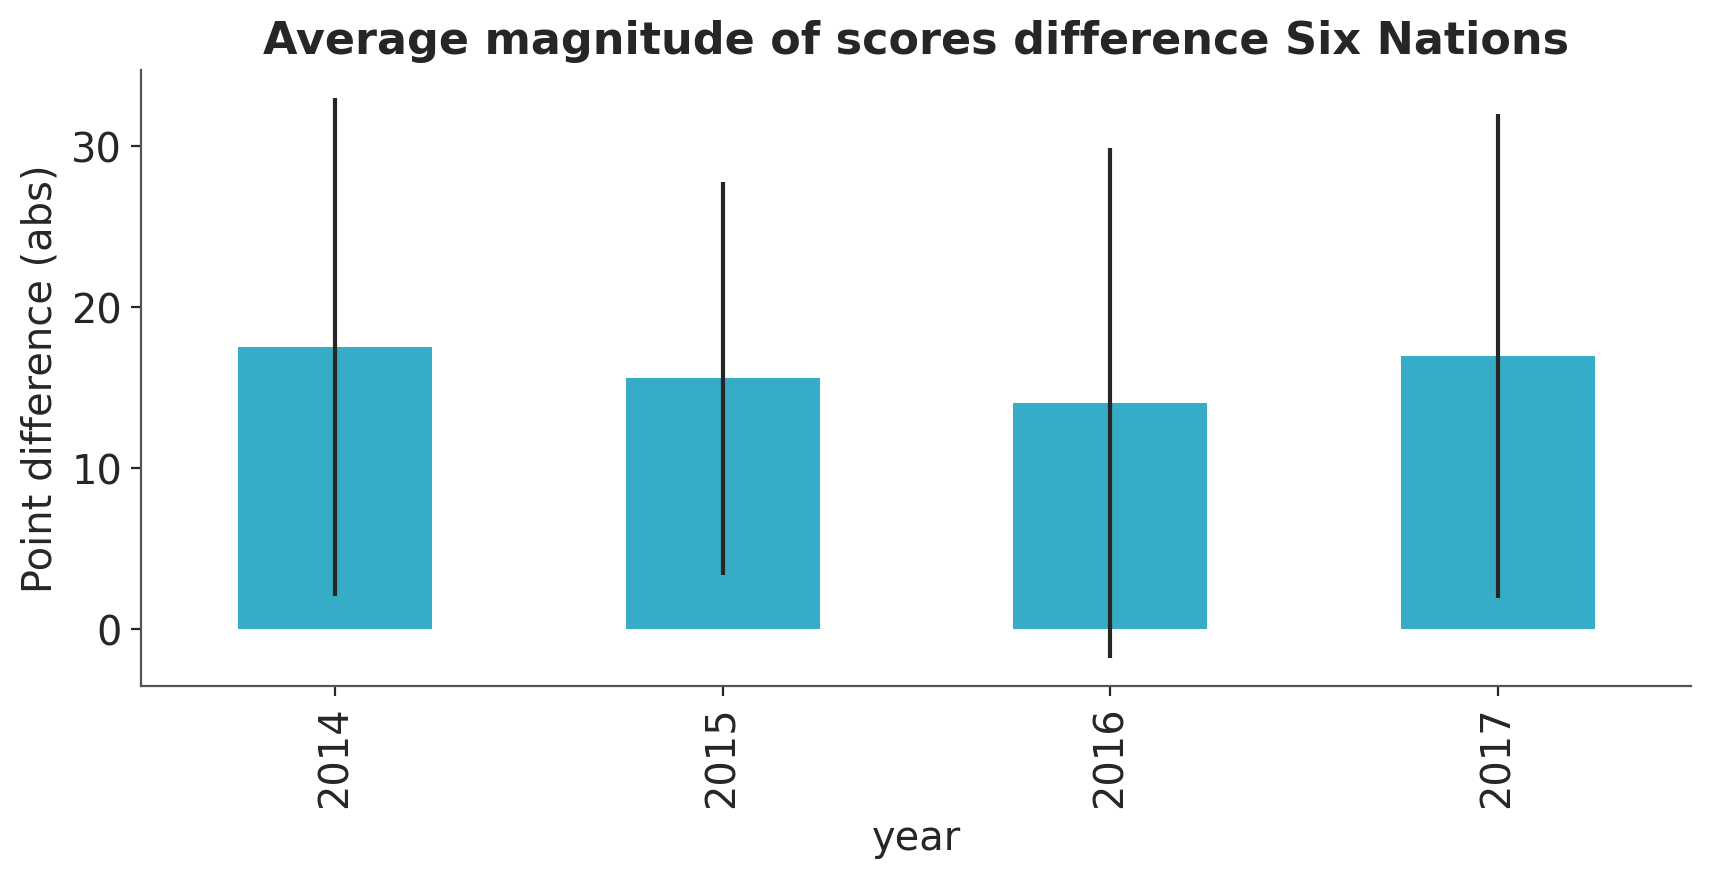

In [7]:
(
    df_all.groupby("year")["difference"]
    .mean()
    .plot(
        kind="bar",
        title="Average magnitude of scores difference Six Nations",
        yerr=df_all.groupby("year")["difference"].std(),
        figsize=(10, 4),
    )
    .set_ylabel("Point difference (abs)")
);

We can see that the standard error is large. So we can't say anything about the differences.
Let's look country by country.

In [8]:
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]

Let us first look at a Pivot table with a sum of this, broken down by year.

In [9]:
df_all.pivot_table("difference_non_abs", "home_team", "year")

year,2014,2015,2016,2017
home_team,,,,
England,7.000000,20.666667,7.500000,21.333333
France,6.666667,0.000000,-2.333333,4.000000
Ireland,28.000000,8.500000,17.666667,7.000000
Italy,-21.000000,-31.000000,-23.500000,-33.666667
Scotland,-11.000000,-12.000000,2.500000,16.666667
Wales,25.666667,1.000000,22.000000,4.000000


Now let's first plot this by home team without year.

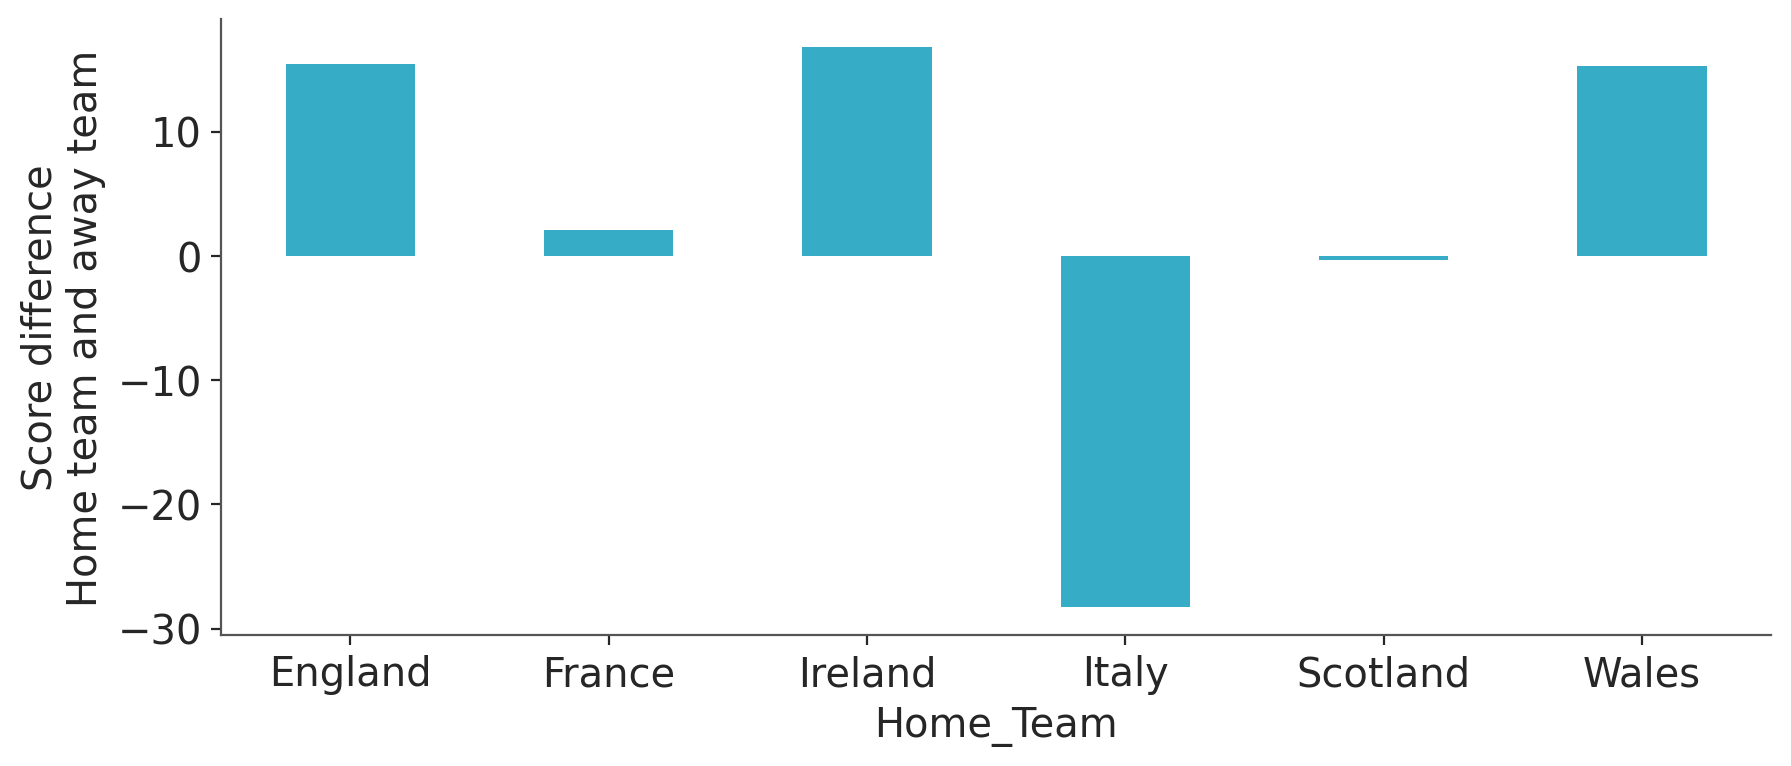

In [10]:
(
    df_all.pivot_table("difference_non_abs", "home_team")
    .rename_axis("Home_Team")
    .plot(kind="bar", rot=0, legend=False, figsize=(10, 4))
    .set_ylabel("Score difference\nHome team and away team")
);

You can see that Italy and Scotland have negative scores on average. You can also see that England, Ireland and Wales have been the strongest teams lately at home.

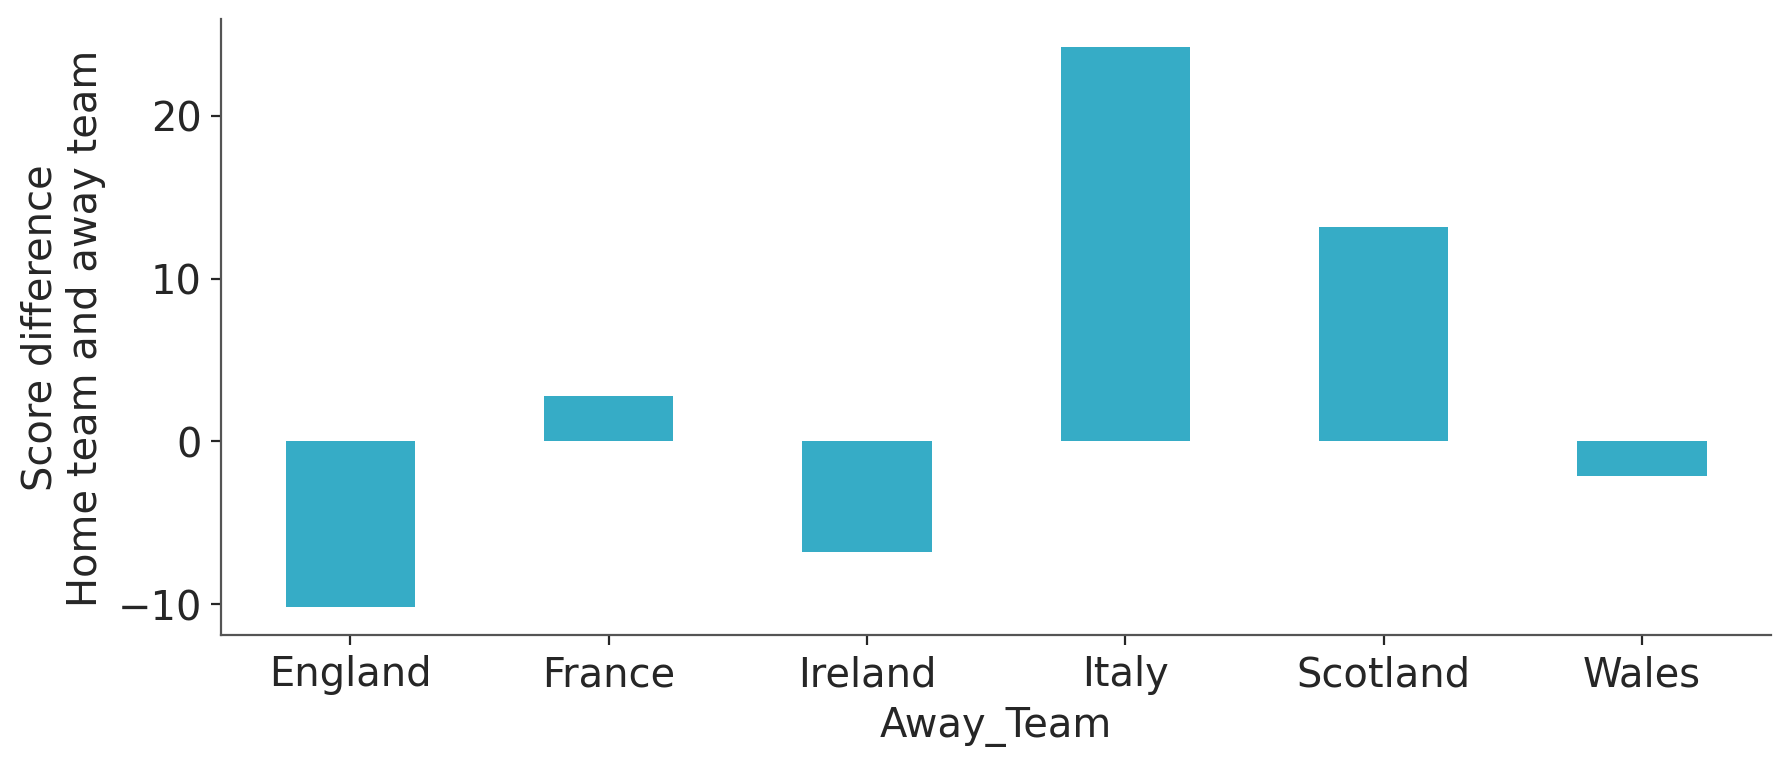

In [11]:
(
    df_all.pivot_table("difference_non_abs", "away_team")
    .rename_axis("Away_Team")
    .plot(kind="bar", rot=0, legend=False, figsize=(10, 4))
    .set_ylabel("Score difference\nHome team and away team")
);

This indicates that Italy, Scotland and France all have poor away from home form.
England suffers the least when playing away from home. This aggregate view doesn't take into account the strength of the teams.

Let us look a bit more at a timeseries plot of the average of the score difference over the year.

We see some changes in team behaviour, and we also see that Italy is a poor team.

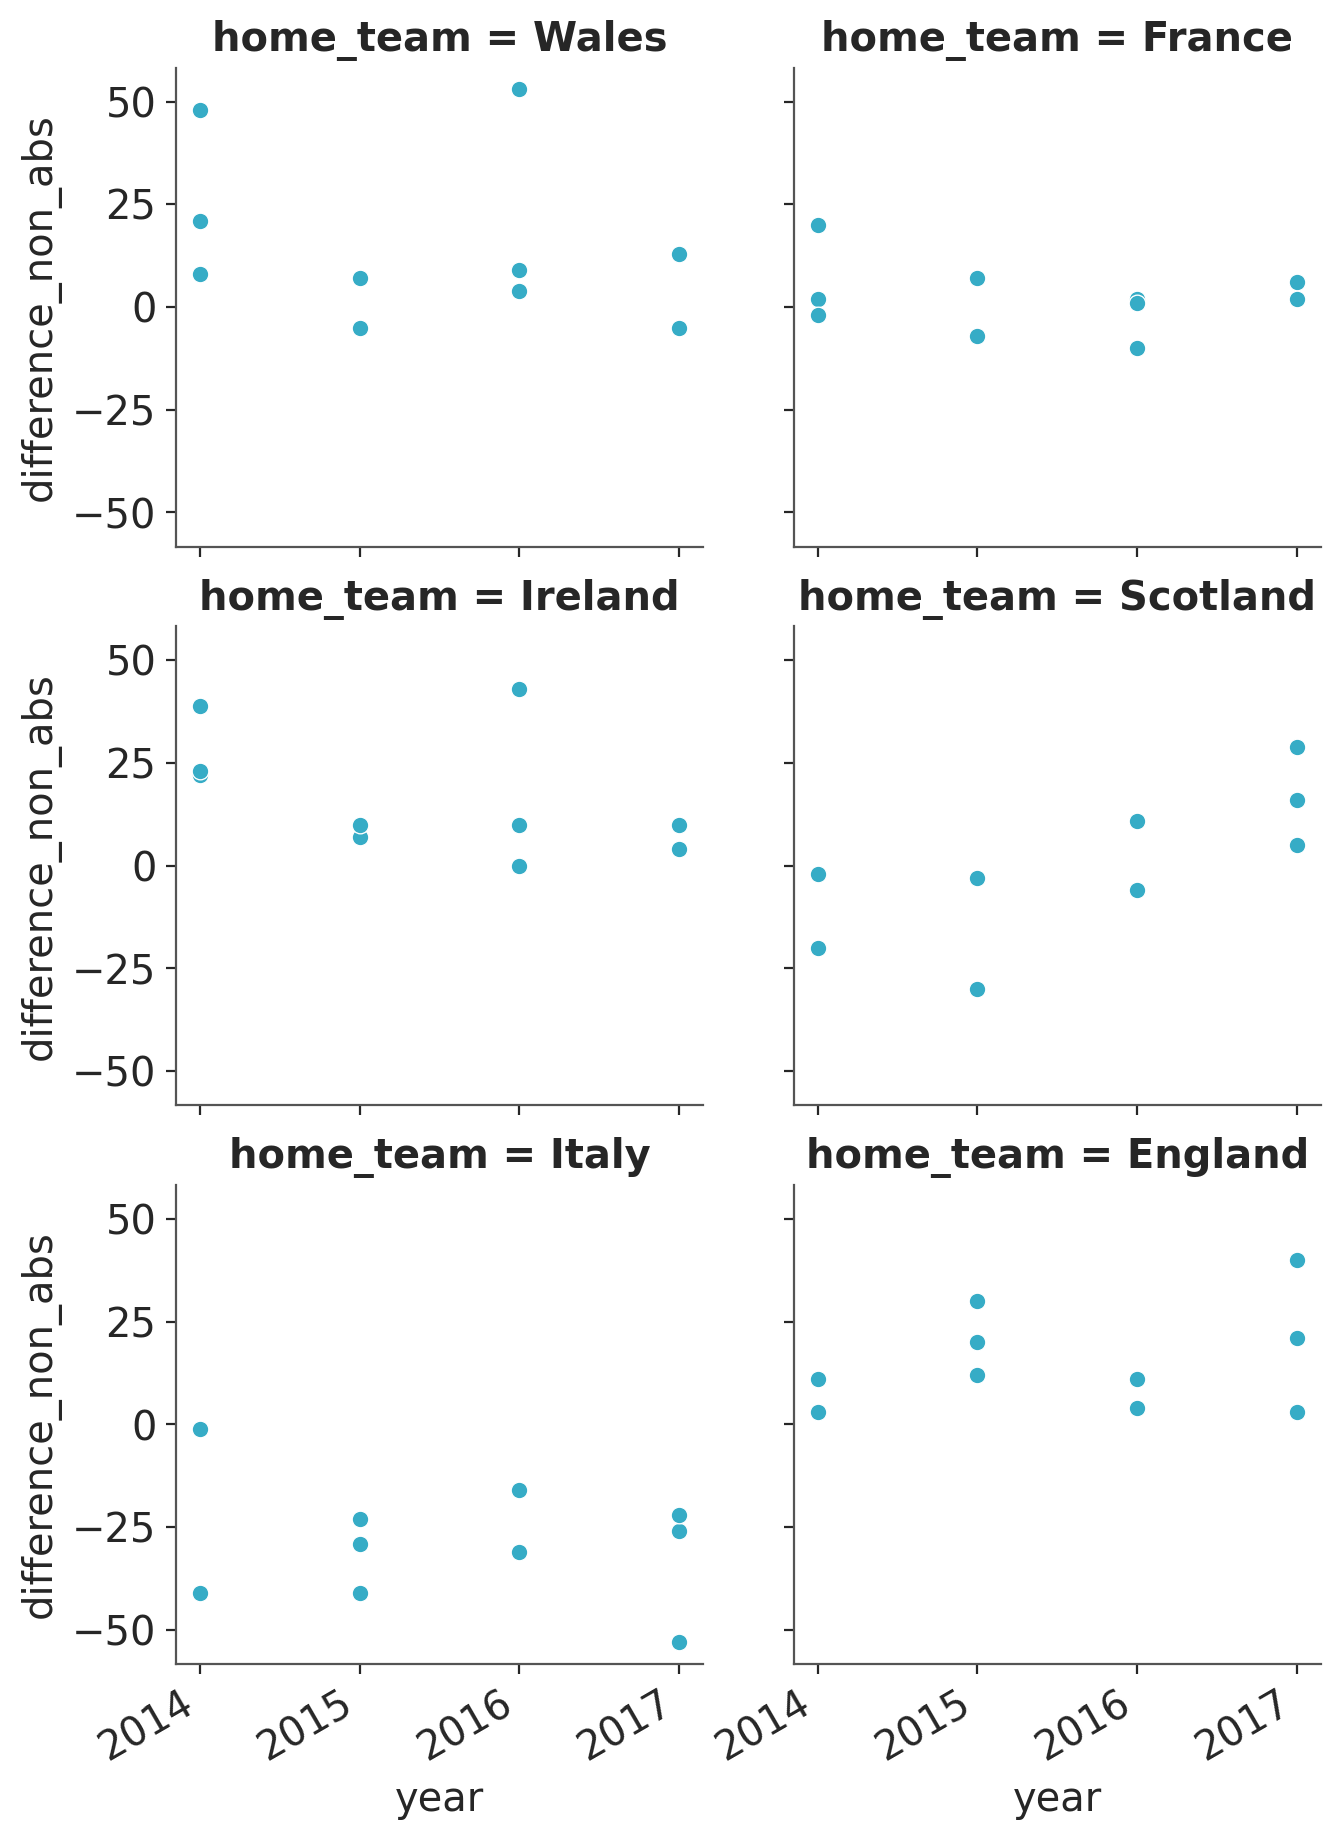

In [12]:
g = sns.FacetGrid(df_all, col="home_team", col_wrap=2, height=3.5)
g.map(sns.scatterplot, "year", "difference_non_abs")
g.fig.autofmt_xdate()

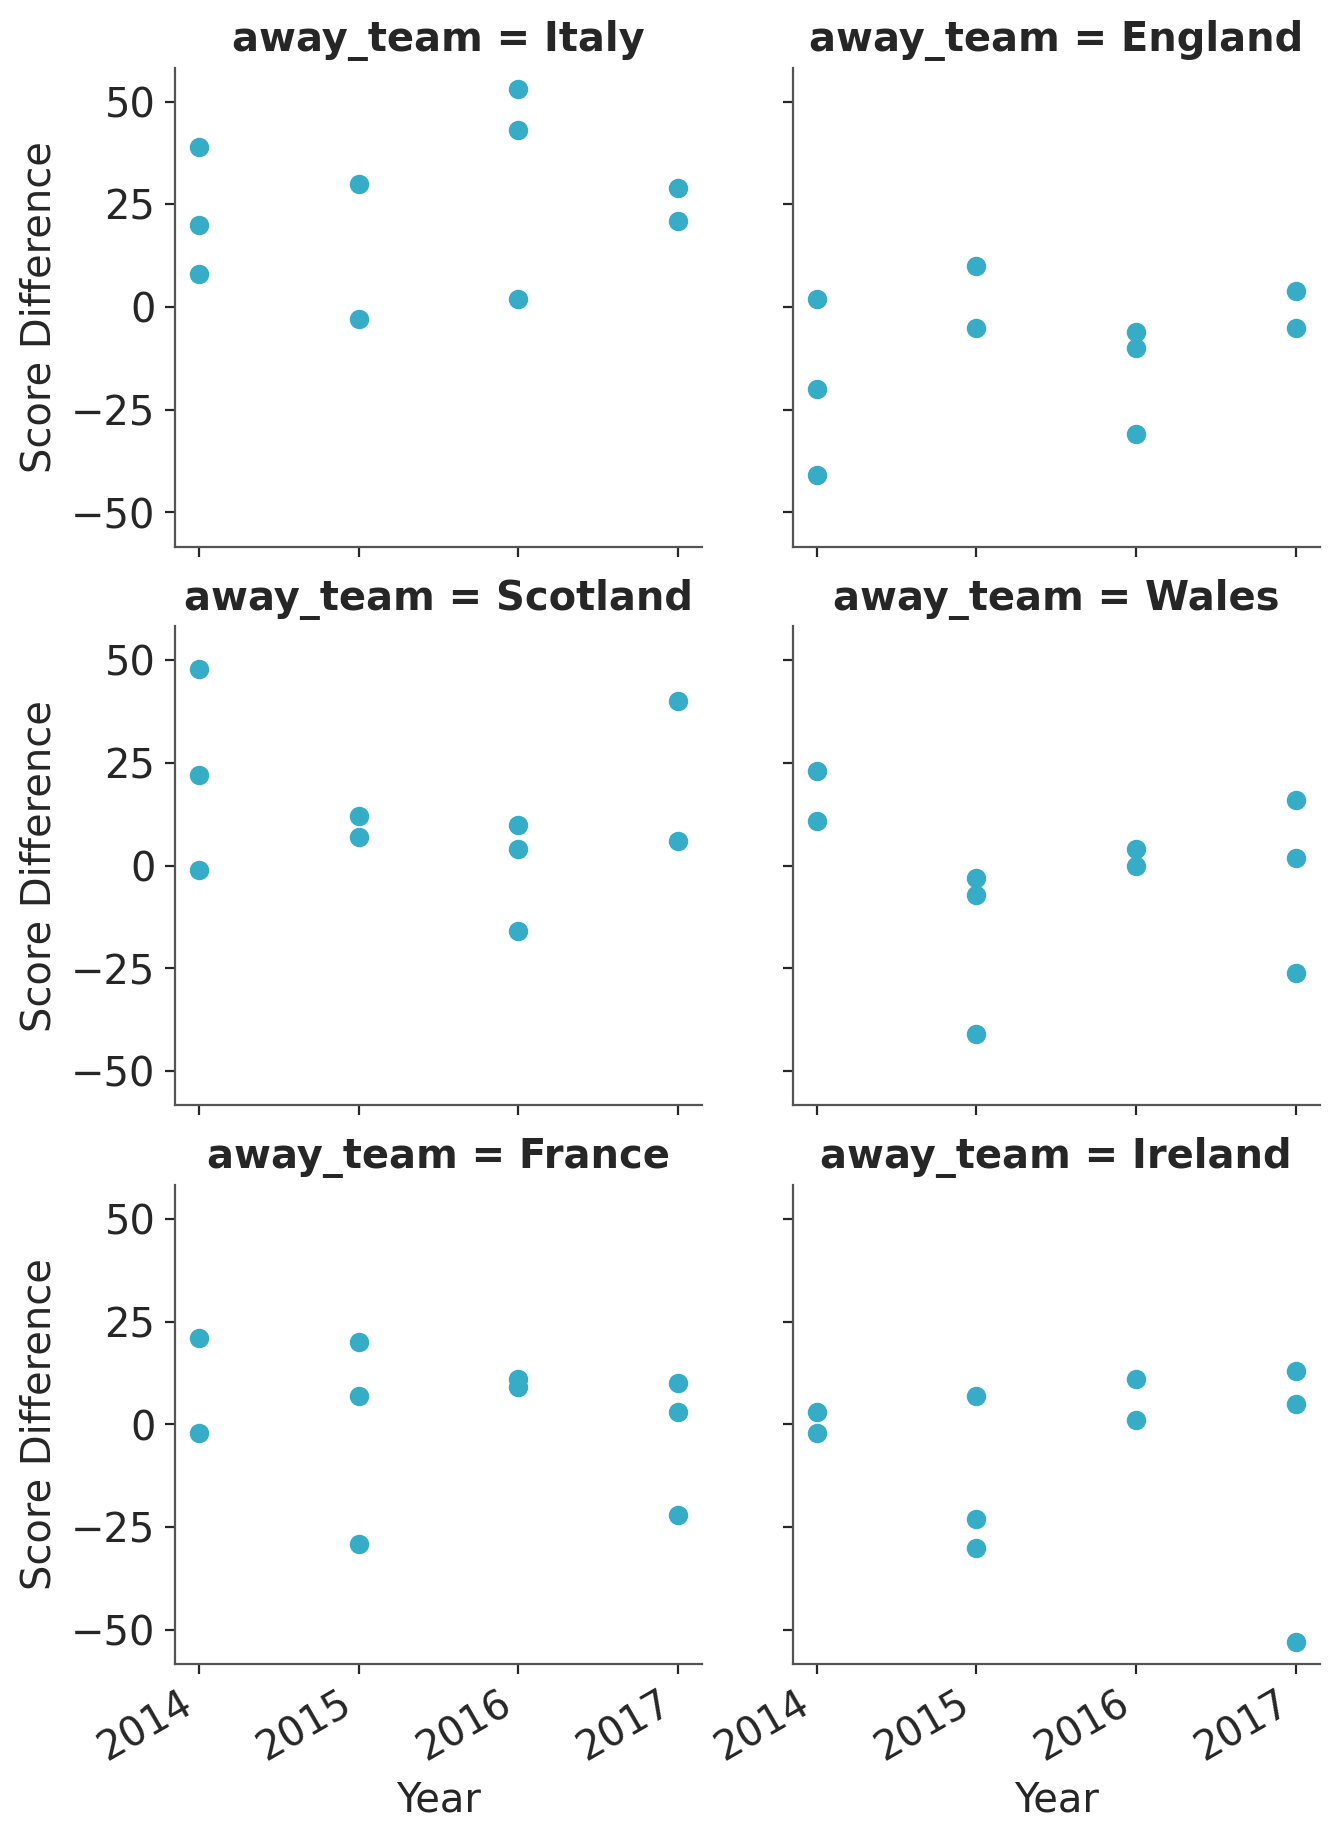

In [13]:
g = sns.FacetGrid(df_all, col="away_team", col_wrap=2, height=3.5)
g = g.map(plt.scatter, "year", "difference_non_abs").set_axis_labels("Year", "Score Difference")
g.fig.autofmt_xdate()

You can see some interesting things here like Wales were good away from home in 2015.
In that year they won three games away from home and won by 40 points or so away from home to Italy.

So now we've got a feel for the data, we can proceed on with describing the model.

### What assumptions do we know for our 'generative story'?

* We know that the Six Nations in Rugby only has 6 teams - they each play each other once
* We have data from the last few years
* We also know that in sports scoring is modelled as a Poisson distribution
* We consider home advantage to be a strong effect in sports

## The model.

The league is made up by a total of T= 6 teams, playing each other once
in a season. We indicate the number of points scored by the home and the away team in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
The vector of observed counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
$y_{gi}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$
where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
$$log \theta_{g1} = home + att_{h(g)} + def_{a(g)} $$
$$log \theta_{g2} = att_{a(g)} + def_{h(g)}$$


* The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
* The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

* Conversely, for each t = 1, ..., T, the team-specific effects are modelled as exchangeable from a common distribution:

* $att_{t} \; \tilde\;\; Normal(\mu_{att},\tau_{att})$ and $def_{t} \; \tilde\;\;Normal(\mu_{def},\tau_{def})$

* We did some munging above and adjustments of the data to make it **tidier** for our model.
* The log function to away scores and home scores is a standard trick in the sports analytics literature

## Building of the model
We now build the model in PyMC, specifying the global parameters, the team-specific parameters and the likelihood function

In [14]:
plt.rcParams["figure.constrained_layout.use"] = True
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)
coords = {"team": teams}

In [15]:
with pm.Model(coords=coords) as model:
    # constant data
    home_team = pm.Data("home_team", home_idx, dims="match")
    away_team = pm.Data("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims="team")
    home_theta = pt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = pt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )
    trace = pm.sample(1000, tune=1500, cores=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]


Output()

Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 7 seconds.


* We specified the model and the likelihood function

* All this runs on an PyTensor graph under the hood

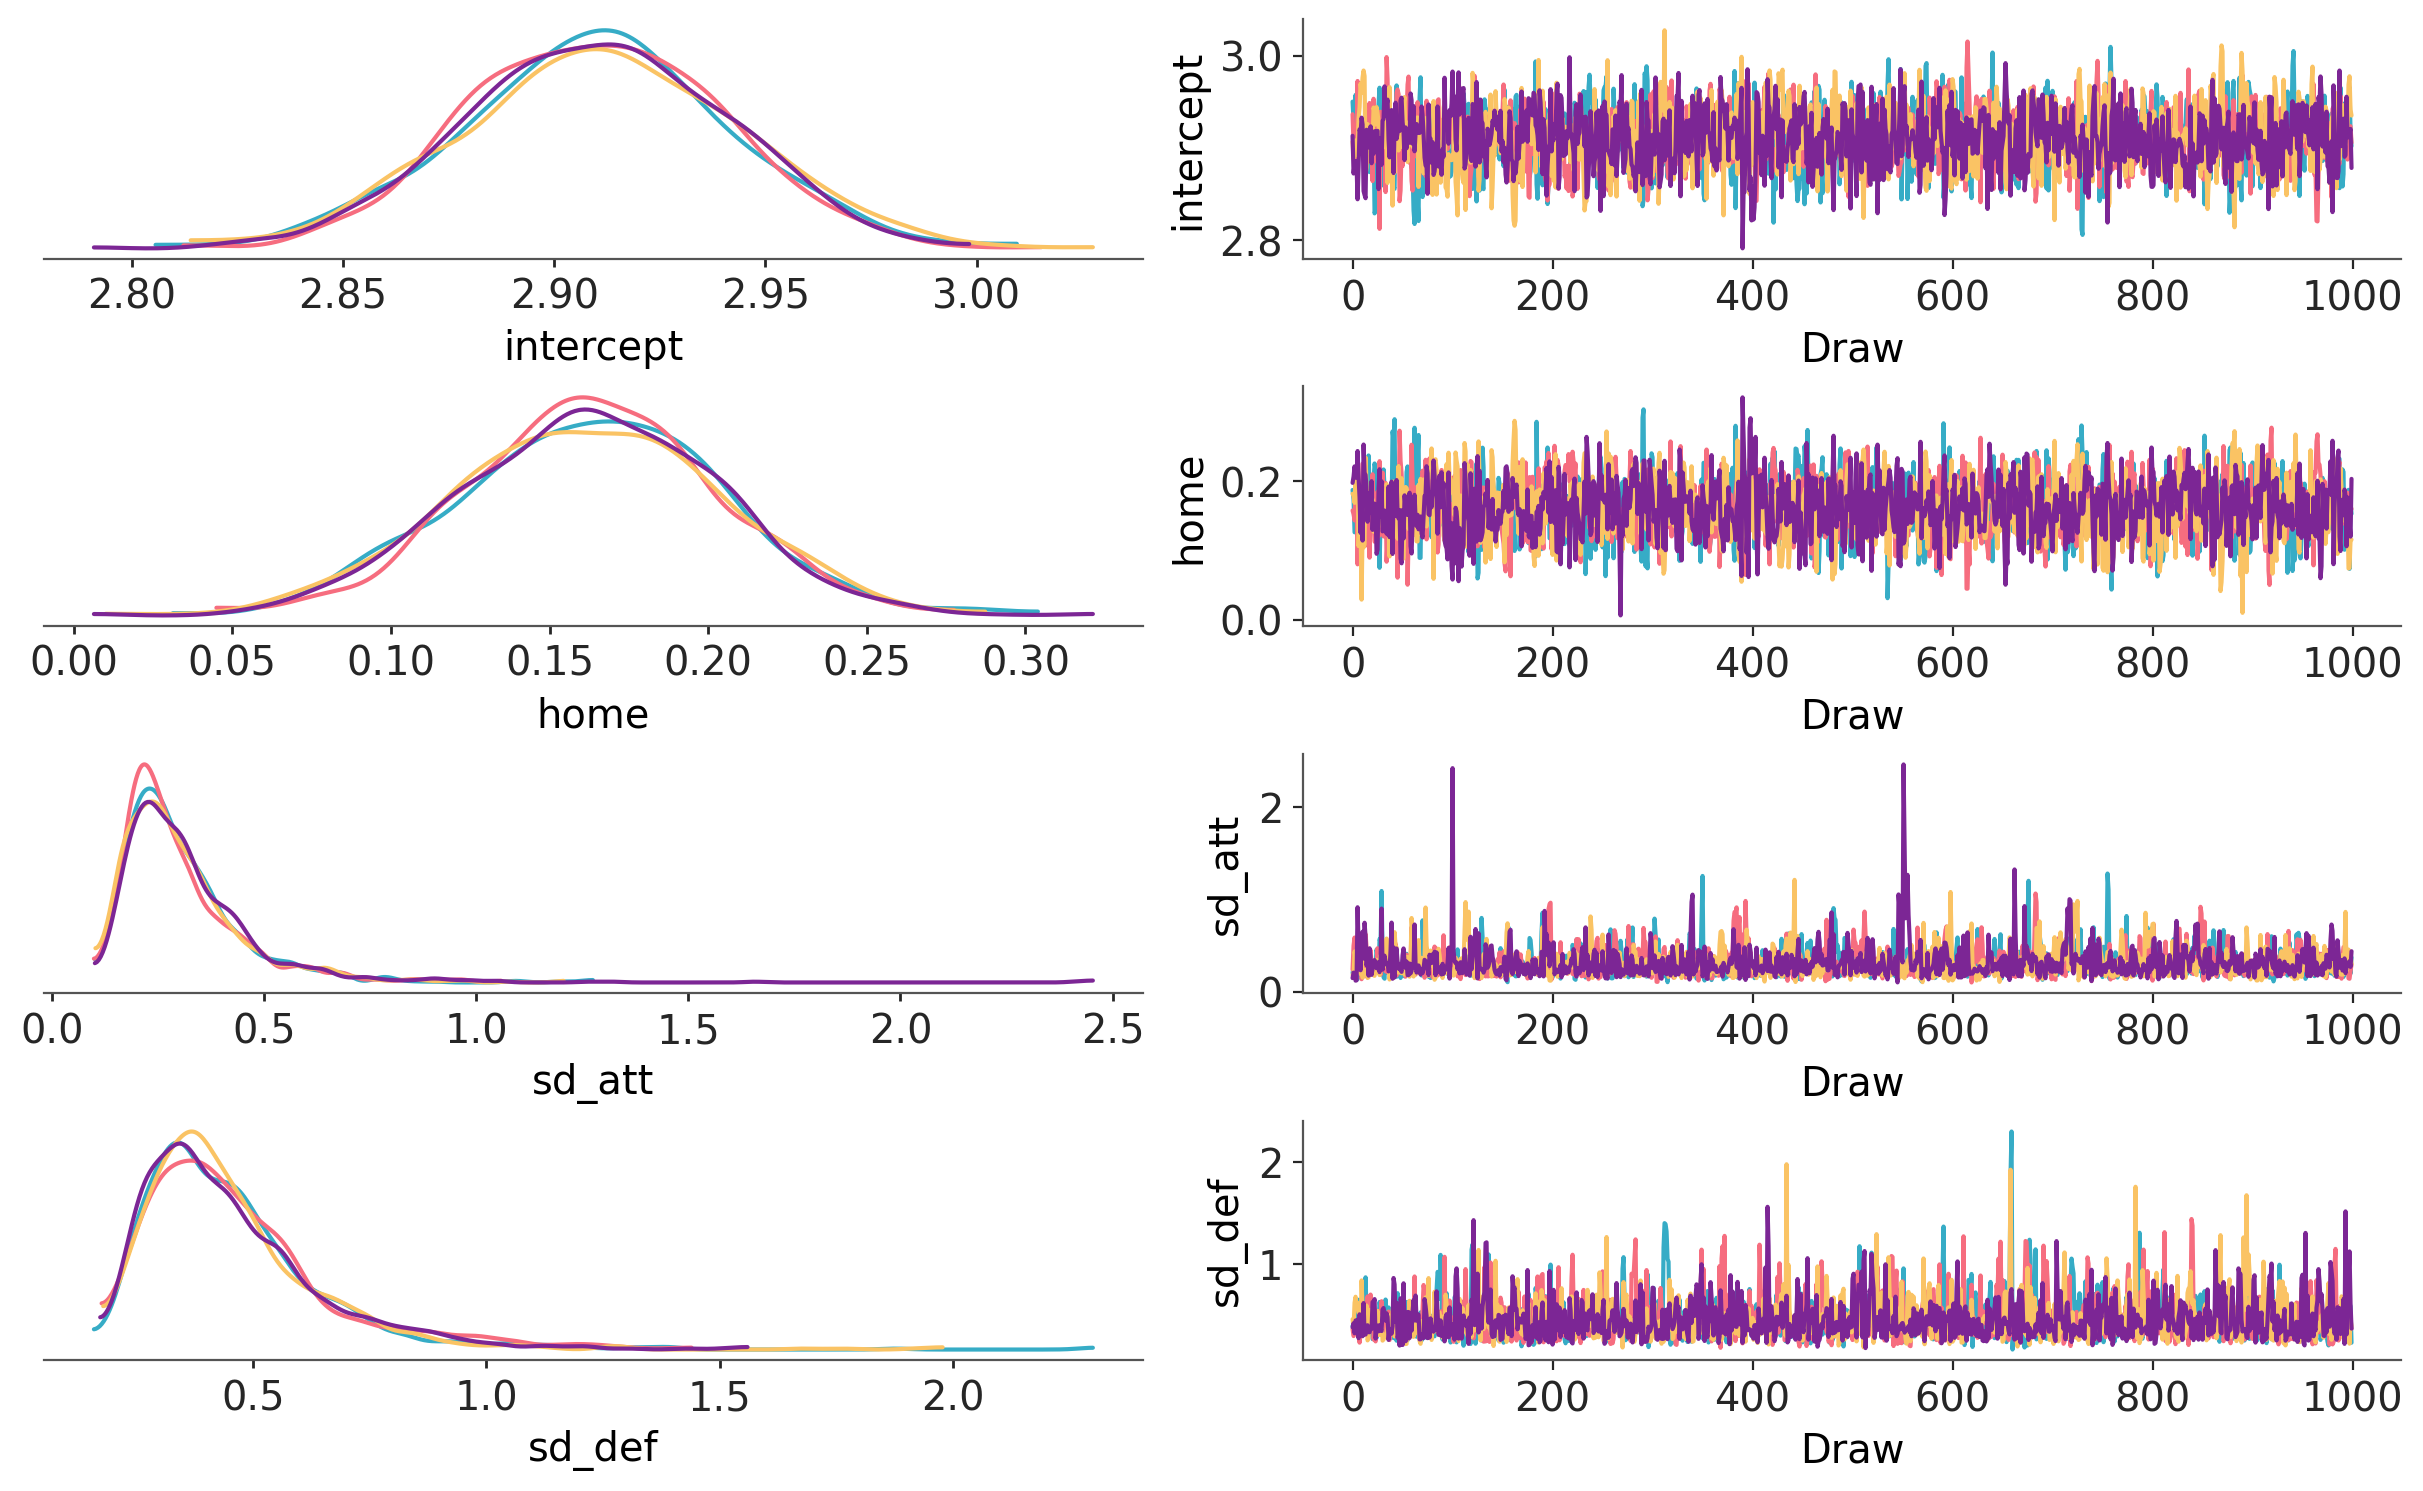

In [16]:
az.plot_trace_dist(trace, var_names=["intercept", "home", "sd_att", "sd_def"], compact=False);

Let us apply good *statistical workflow* practices and look at the various evaluation metrics to see if our NUTS sampler converged.

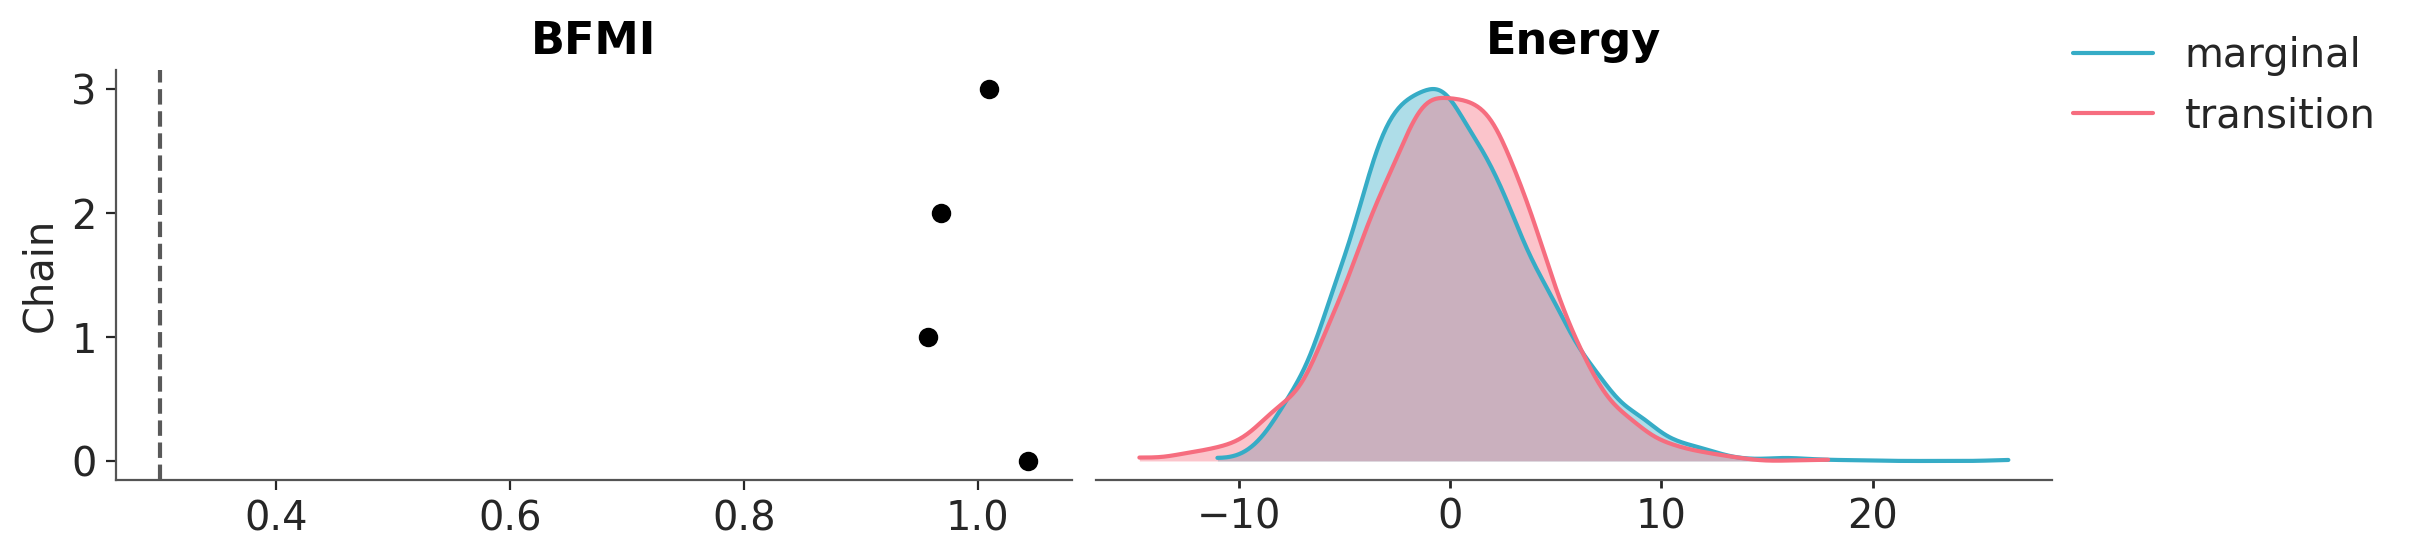

In [17]:
az.plot_energy(trace);

In [18]:
az.summary(trace, kind="diagnostics")

,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
home,2542.56,2396.14,1.0,0.00,0.00
intercept,2618.35,2187.92,1.0,0.00,0.00
atts_star[England],1346.40,1321.64,1.0,0.00,0.00
atts_star[France],1409.48,1466.08,1.0,0.00,0.00
atts_star[Ireland],1245.27,1408.08,1.0,0.00,0.00
atts_star[Italy],1387.79,1516.17,1.0,0.00,0.00
atts_star[Scotland],1262.72,1380.65,1.0,0.00,0.00
atts_star[Wales],1277.02,1315.53,1.0,0.00,0.00
defs_star[England],1498.60,1587.52,1.0,0.01,0.00
defs_star[France],1462.39,1538.39,1.0,0.01,0.00


Our model has converged well and $\hat{R}$ looks good.

Let us look at some of the stats, just to verify that our model has returned the correct attributes. We can see that some teams are stronger than others. This is what we would expect with attack

In [19]:
trace_hdi = az.hdi(trace)
trace_hdi["atts"]

<xarray.DataArray 'atts' (team: 6, ci_bound: 2)> Size: 96B
array([[ 0.19171627,  0.32208636],
       [-0.15623334, -0.00648777],
       [ 0.04211947,  0.17642929],
       [-0.41985708, -0.24002752],
       [-0.19231374, -0.04272834],
       [ 0.11211103,  0.24132075]])
Coordinates:
  * ci_bound  (ci_bound) <U5 40B 'lower' 'upper'
  * team      (team) <U8 192B 'England' 'France' ... 'Scotland' 'Wales'

In [20]:
trace.posterior["atts"].median(("chain", "draw"))

<xarray.DataArray 'atts' (team: 6)> Size: 48B
array([ 0.25674891, -0.08486691,  0.10654883, -0.33506284, -0.11549775,
        0.17115289])
Coordinates:
  * team     (team) <U8 192B 'England' 'France' 'Ireland' ... 'Scotland' 'Wales'

## Results
From the above we can start to understand the different distributions of attacking strength and defensive strength.
These are probabilistic estimates and help us better understand the uncertainty in sports analytics

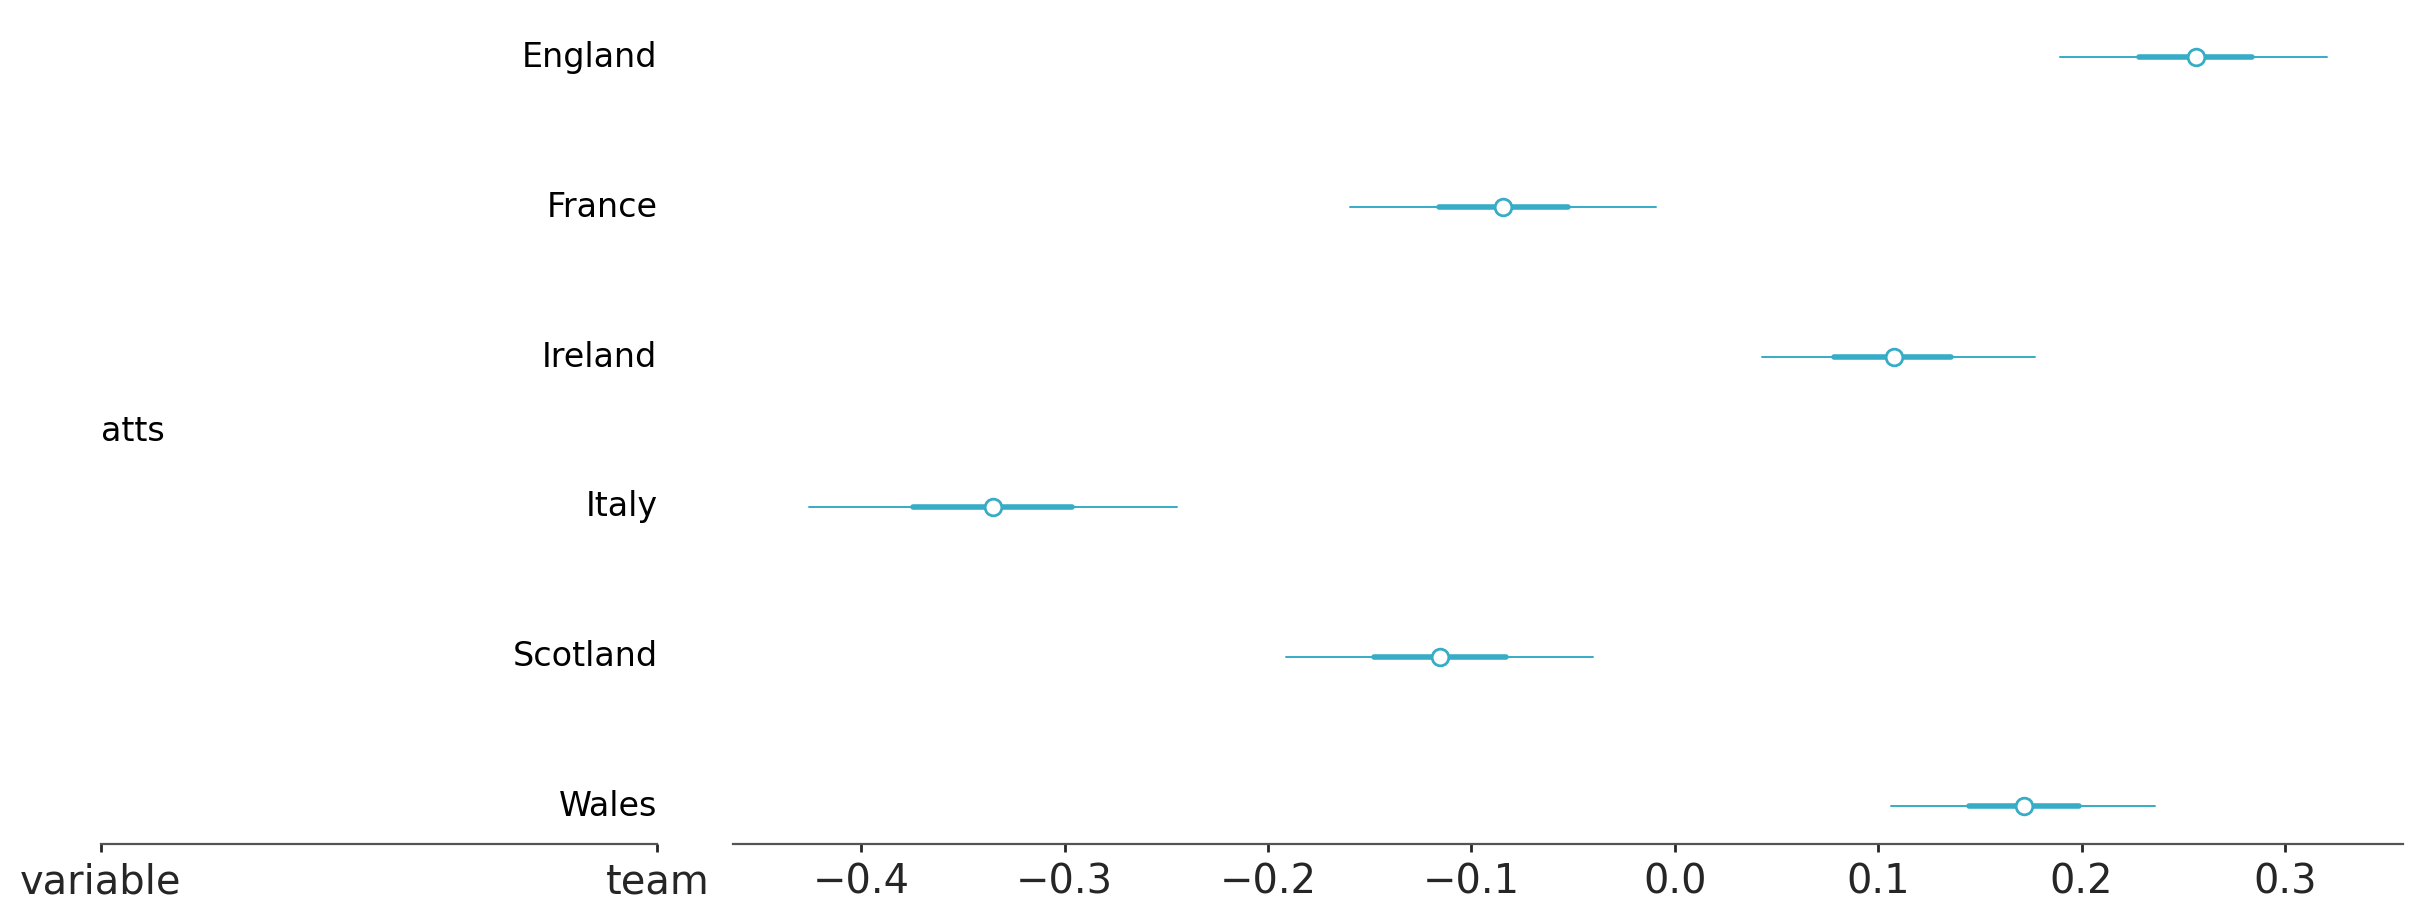

In [21]:
az.plot_forest(trace, var_names=["atts"], combined=True);

This is one of the powerful things about Bayesian modelling, we can have *uncertainty quantification* of our estimates.
We've got a Bayesian credible interval for the attack strength of different countries.

We can see an overlap between Ireland, Wales and England which is what you'd expect since these teams have won in recent years.

Italy is well behind everyone else - which is what we'd expect and there's an overlap between Scotland and France which seems about right.

There are probably some effects we'd like to add in here, like weighting more recent results more strongly.
However that'd be a much more complicated model.

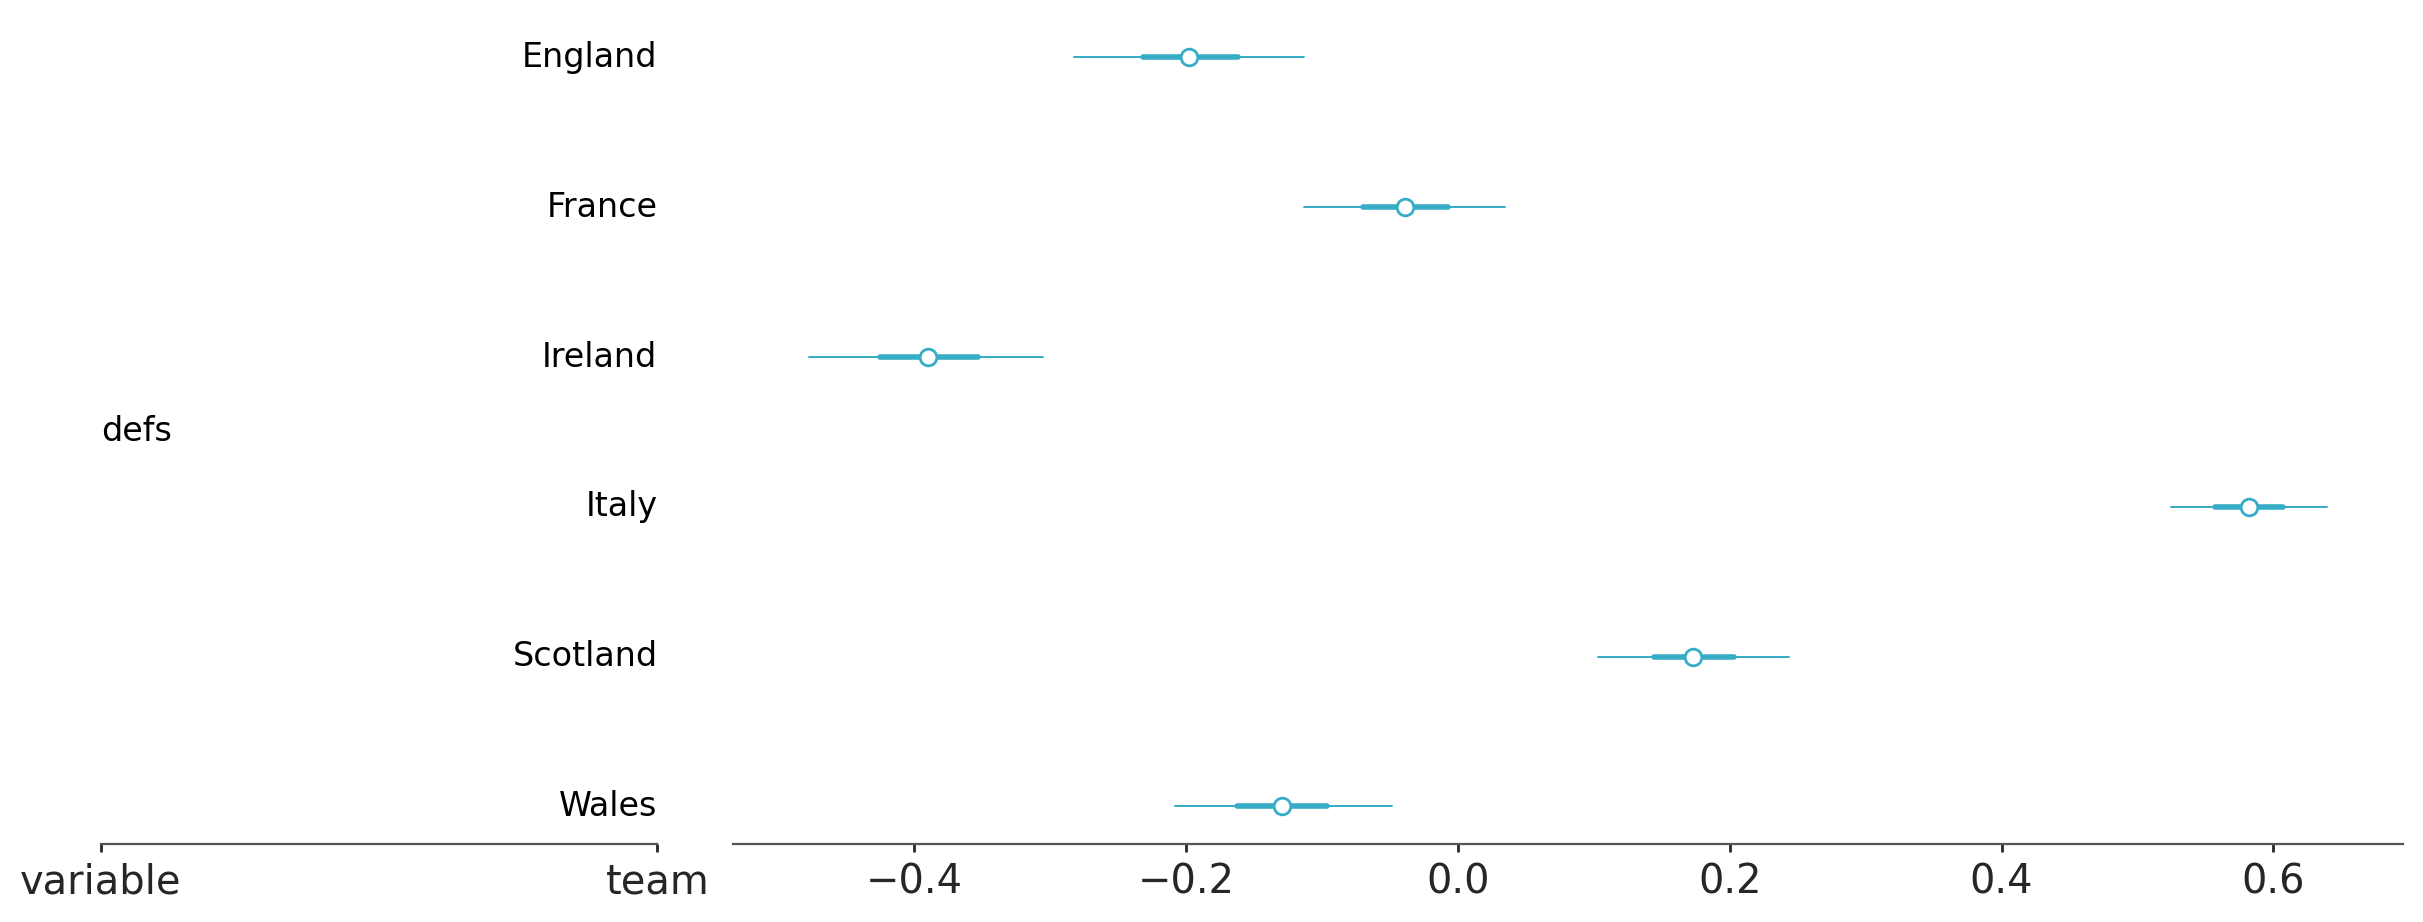

In [22]:
az.plot_forest(trace, var_names=["defs"], combined=True);

Good teams like Ireland and England have a strong negative effect defense. Which is what we expect. We expect our strong teams to have strong positive effects in attack and strong negative effects in defense.

This approach that we're using of looking at parameters and examining them is part of a good statistical workflow.
We also think that perhaps our priors could be better specified. However this is beyond the scope of this article.
We recommend for a good discussion of 'statistical workflow' you visit [Robust Statistical Workflow with RStan](http://mc-stan.org/users/documentation/case-studies/rstan_workflow.html)

Let's do some other plots. So we can see our range for our defensive effect.
I'll print the teams below too just for reference

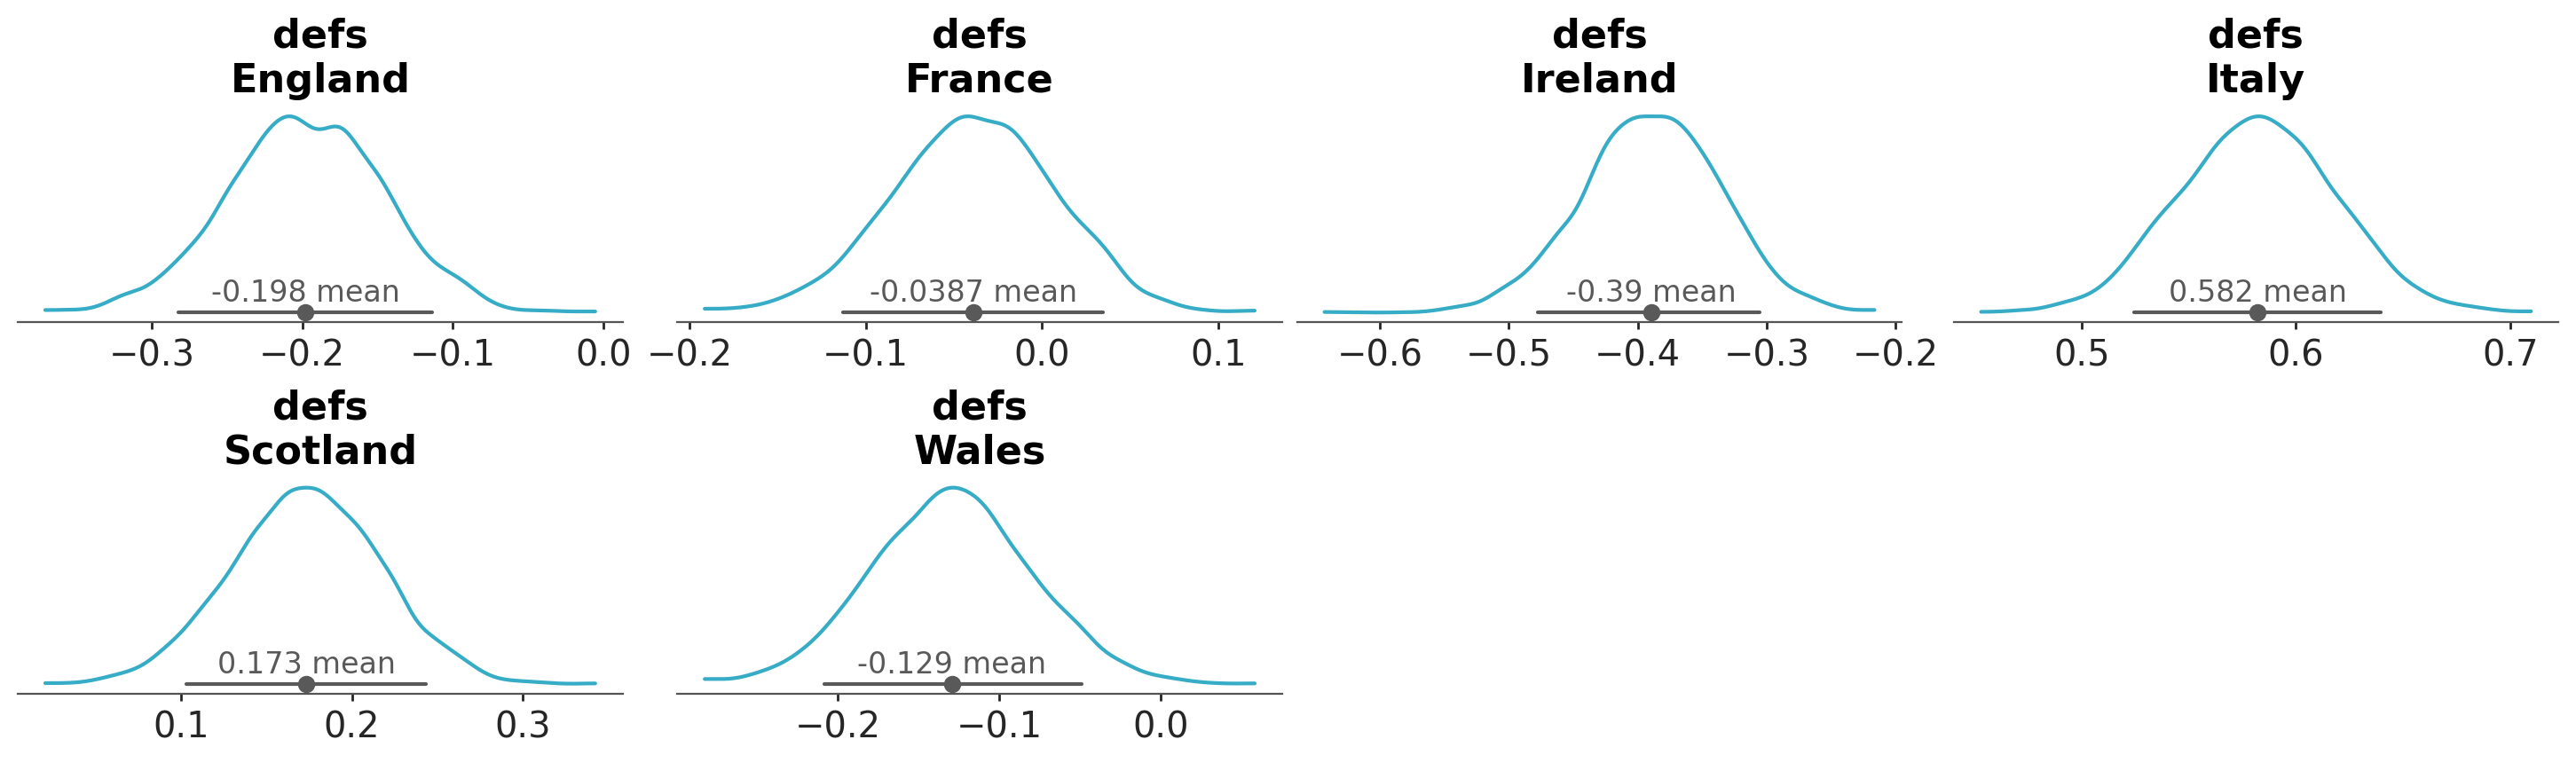

In [23]:
az.plot_dist(trace, var_names=["defs"]);

We can see that Ireland's mean is -0.39  which means we expect Ireland to have a strong defense.
Which is what we'd expect, Ireland generally even in games it loses doesn't lose by say 50 points.
And we can see that the 94% HDI is between -0.491, and -0.28

In comparison with Italy, we see a strong positive effect 0.58 mean and a HDI of 0.51 and 0.65. This means that we'd expect Italy to concede a lot of points, compared to what it scores.
Given that Italy often loses by 30 - 60 points, this seems correct.

We see here also that this informs what other priors we could bring into this. We could bring some sort of world ranking as a prior.

As of December 2017 the [rugby rankings](https://www.worldrugby.org/rankings/mru) indicate that England is 2nd in the world, Ireland 3rd, Scotland 5th, Wales 7th, France 9th and Italy 14th. We could bring that into a model and it can explain some of the fact that Italy is apart from a lot of the other teams.

Now let's simulate who wins over a total of 4000 simulations, one per sample in the posterior.

In [24]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
pp = trace.posterior_predictive
const = trace.constant_data
team_da = trace.posterior.team

Sampling: [away_points, home_points]


Output()

The posterior predictive samples contain the goals scored by each team in each match. We modeled and therefore simulated according to scoring and devensive powers using goals as observed variable.

Our goal now is to see who wins the competition, so we can estimate the probability each team has of winning the whole competition. From that we need to convert the scored goals to points:

In [25]:
# fmt: off
pp["home_win"] = (
    (pp["home_points"] > pp["away_points"]) * 3     # home team wins and gets 3 points
    + (pp["home_points"] == pp["away_points"]) * 2  # tie -> home team gets 2 points
)
pp["away_win"] = (
    (pp["home_points"] < pp["away_points"]) * 3
    + (pp["home_points"] == pp["away_points"]) * 2
)
# fmt: on

Then add the points each team has collected throughout all matches:

In [26]:
groupby_sum_home = pp.home_win.groupby(team_da[const.home_team]).sum()
groupby_sum_away = pp.away_win.groupby(team_da[const.away_team]).sum()

pp["teamscores"] = groupby_sum_home + groupby_sum_away

And eventually generate the ranks of all teams for each of the 4000 simulations. As our data is stored in xarray objects inside the InferenceData class, we will use {doc}`einstats:index`:

In [27]:
from xarray_einstats.stats import rankdata

pp["rank"] = rankdata(-pp["teamscores"], dims="team", method="min")
pp[["rank"]].sel(team="England")

<xarray.Dataset> Size: 40kB
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    team     <U7 28B 'England'
Data variables:
    rank     (chain, draw) int64 32kB 3 1 1 2 2 1 1 2 3 2 ... 2 3 2 2 1 2 2 1 1
Attributes:
    created_at:                 2025-12-15T10:34:13.017540+00:00
    arviz_version:              0.23.0.dev0
    inference_library:          pymc
    inference_library_version:  5.26.1

As you can see, we now have a collection of 4000 integers between 1 and 6 for each team, 1 meaning they win the competition. We can use a histogram with bin edges at half integers to count and normalize how many times each team
finishes in each position:

In [28]:
from xarray_einstats.numba import histogram

bin_edges = np.arange(7) + 0.5
data_sim = (
    histogram(pp["rank"], dims=("chain", "draw"), bins=bin_edges, density=True)
    .rename({"bin": "rank"})
    .assign_coords(rank=np.arange(6) + 1)
)

Now that we have reduced the data to a 2 dimensional array, we will convert it to a pandas DataFrame
which is now a more adequate choice to work with our data:

In [29]:
idx_dim, col_dim = data_sim.dims
sim_table = pd.DataFrame(data_sim, index=data_sim[idx_dim], columns=data_sim[col_dim])

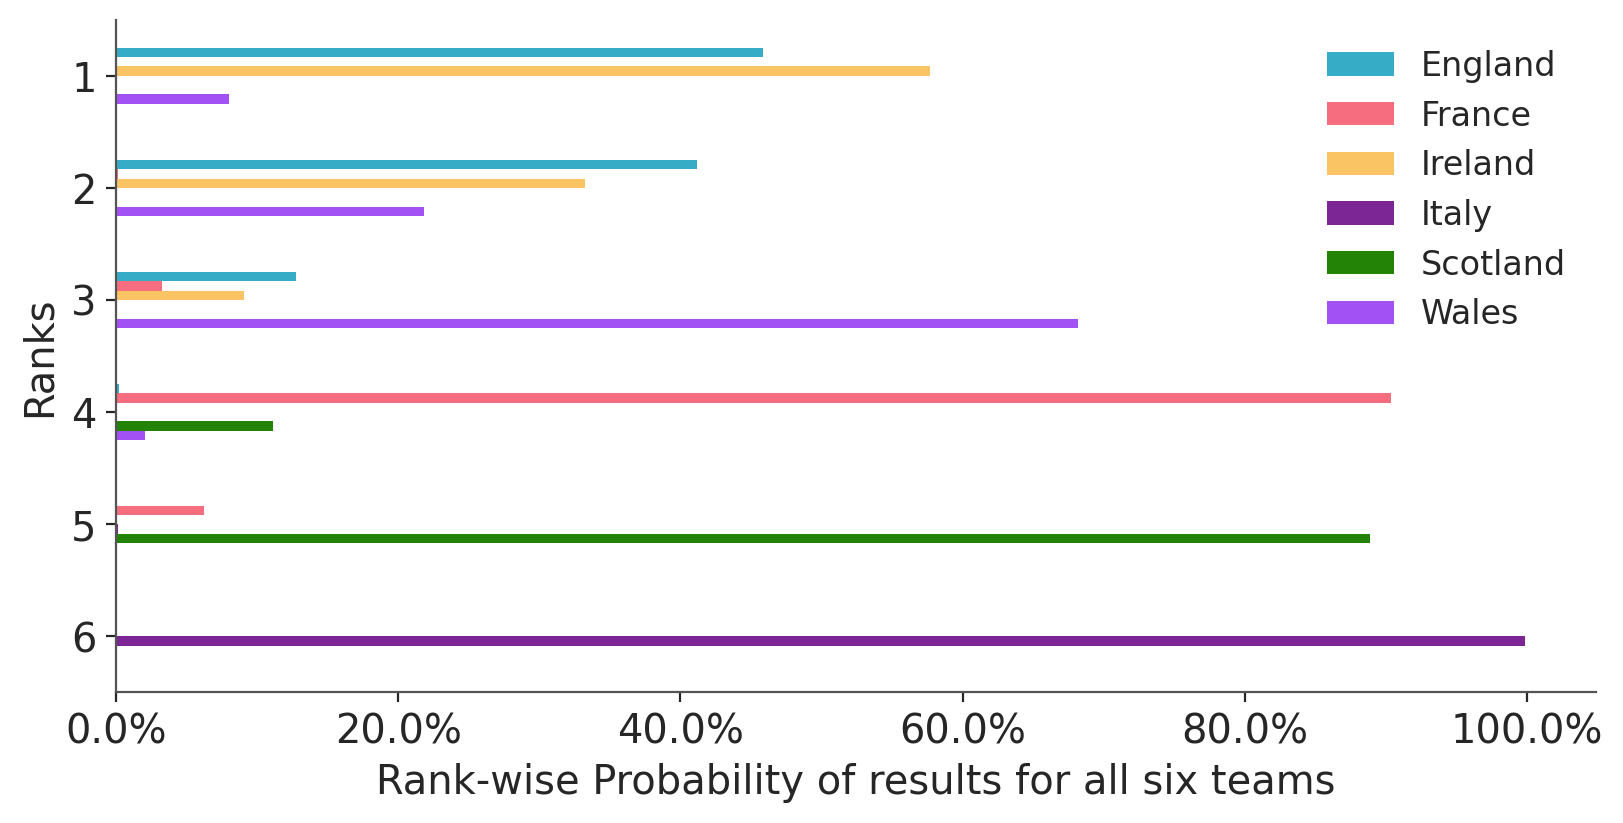

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sim_table.T.plot(kind="barh", ax=ax)
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.1%}"))
ax.set_xlabel("Rank-wise Probability of results for all six teams")
ax.set_yticklabels(np.arange(1, 7))
ax.set_ylabel("Ranks")
ax.invert_yaxis()
ax.legend(loc="best", fontsize="medium");

We see according to this model that Ireland finishes with the most points about 60% of the time, and England finishes with the most points 45% of the time and Wales finishes with the most points about 10% of the time.  (Note that these probabilities do not sum to 100% since there is a non-zero chance of a tie atop the table.)

> As an Irish rugby fan - I like this model. However it indicates some problems with shrinkage, and bias. Since recent form suggests England will win.

Nevertheless the point of this model was to illustrate how a Hierarchical model could be applied to a sports analytics problem, and illustrate the power of PyMC.

## Covariates
We should do some exploration of the variables

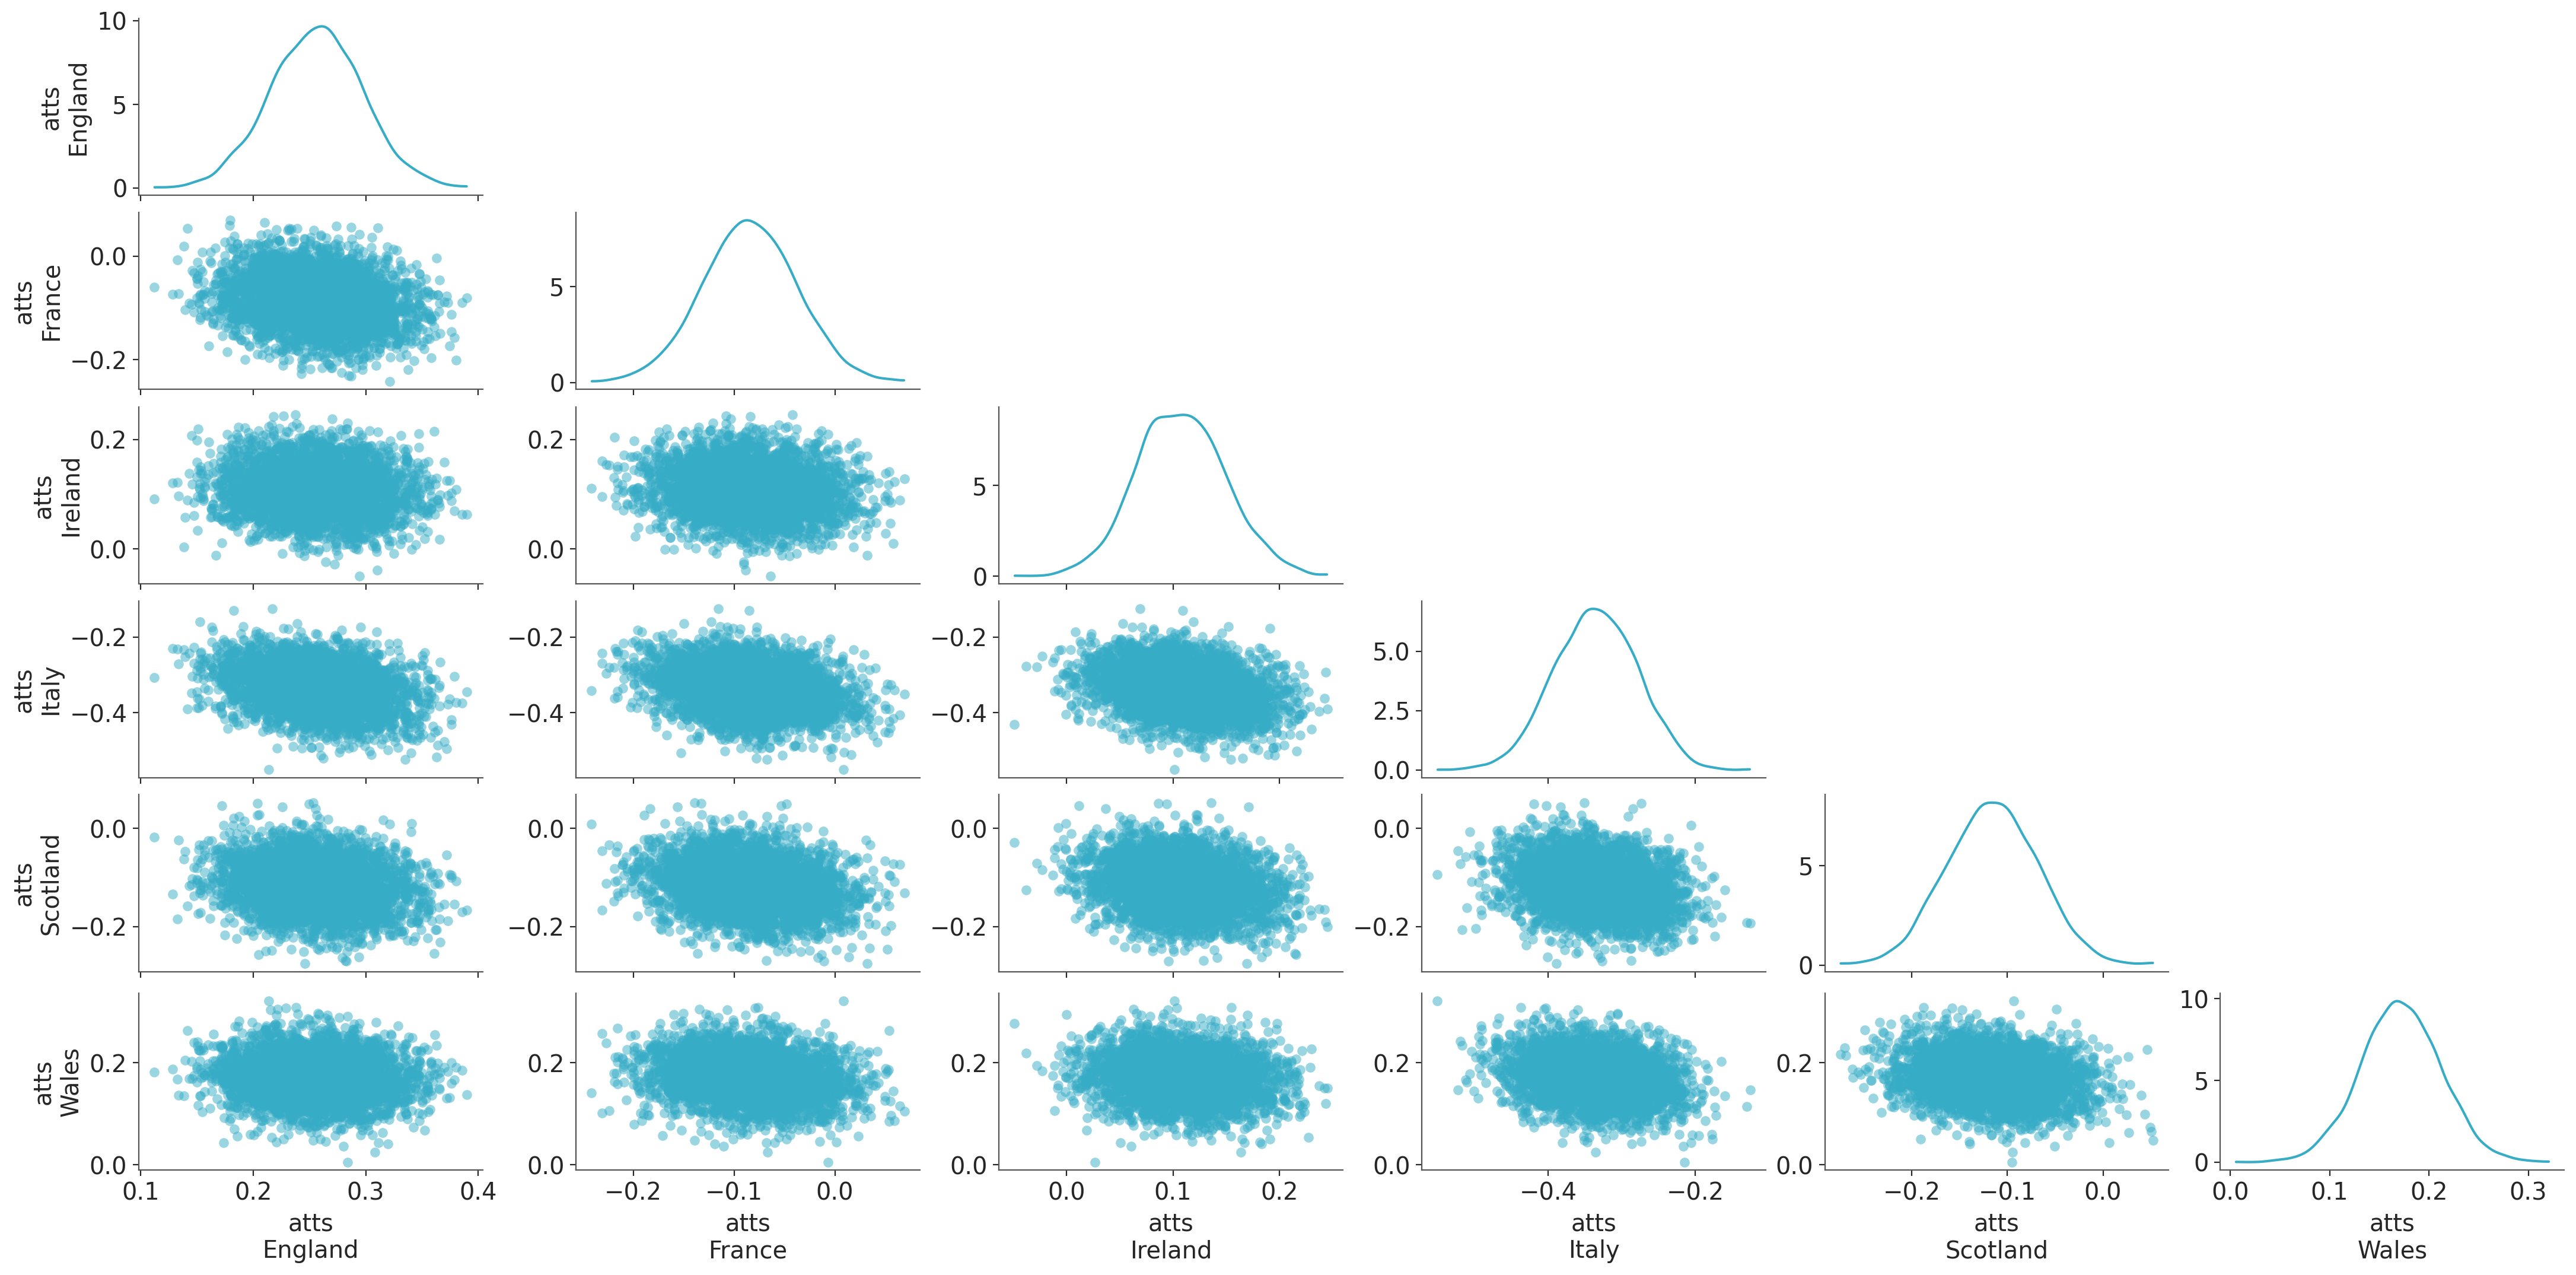

In [31]:
az.plot_pair(
    trace,
    var_names=["atts"],
    visuals={"divergences": True},
);

We observe that there isn't a lot of correlation between these covariates, other than the weaker teams like Italy have a more negative distribution of these variables.
Nevertheless this is a good method to get some insight into how the variables are behaving.

## Authors

* Adapted [Daniel Weitzenfeld's](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) blog post by [Peadar Coyle](). The original blog post was based on the work of {cite:p}`baio2010bayesian`
* Updated by Meenal Jhajharia to use ArviZ and xarray
* Updated by Oriol Abril-Pla to use PyMC v4 and xarray-einstats
* Updated by Osvaldo Martin Dec 2025

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray,aeppl,numba,xarray_einstats

Last updated: Mon Dec 15 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.3.0

xarray         : 2025.6.1
aeppl          : not installed
numba          : 0.61.2
xarray_einstats: 0.9.0

pytensor       : 2.35.1
matplotlib     : 3.10.3
pymc           : 5.26.1
pandas         : 2.3.0
xarray_einstats: 0.9.0
seaborn        : 0.13.2
arviz          : 0.23.0.dev0
numpy          : 2.2.6

Watermark: 2.5.0



:::{include} ../page_footer.md
:::